In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
 
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
 
# Deep learning libraries
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation, Lambda, GlobalAveragePooling2D, DepthwiseConv2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
 
# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
input_path = '/content/drive/My Drive/Cross Validation Data/Fold 3/' #Change it as necessary, This is the base path for data

In [4]:
# Hyperparameters
img_dims = 227
epochs = 50
batch_size = 32

In [5]:
X_train = []
X_test = []
y_train = []
y_test = []

for tt in ['train', 'test']:
  for cond in ['/COVID19/', '/NORMAL/','/PNEUMONIA/']:
    for img_name in os.listdir(input_path+tt+cond):
      img = cv2.imread(input_path+tt+cond+img_name, 0)
      try:
        img = cv2.resize(img, (img_dims, img_dims))
      except:
        print(img_name)
      
      #lbp_img = local_binary_pattern(img, P=8, R=8, method='uniform')/255.0
      img = np.dstack([img, img, img])  #Feinting color image channel
      img = img.astype('float32') / 255.0
      #img = img/255.0
      if tt=='train':
        X_train.append(img)
        
        if cond=='/COVID19/':
          label=0
          y_train.append(label)
        elif cond=='/NORMAL/':
          label=1
          y_train.append(label)
        else:
          label=2
          y_train.append(label)
      else:
        X_test.append(img)
        
        if cond=='/COVID19/':
          label=0
          y_test.append(label)
        elif cond=='/NORMAL/':
          label=1
          y_test.append(label)
        else:
          label=2
          y_test.append(label)


X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
print(X_train.shape, X_test.shape)

(978, 227, 227, 3) (246, 227, 227, 3)


# **First Model to Use**

In [7]:
##########MODEL DESCRIPTION GOES HERE ###############
########### THIS IS MobileNet ########## 
 
num_classes=3
 
IMAGE_SIZE = [227,227]
mobilenet = tf.keras.applications.MobileNet(input_shape = IMAGE_SIZE + [3], weights = None ,alpha=1.0,dropout=0.001, include_top = False)
 
for layer in mobilenet.layers:
  layer.trainable=False
 
########### Make sure the Number of Dense Layers and Number of Neurons are the same as you had saved
x = Flatten()(mobilenet.output)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
x=Dropout(.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

model1 = Model(inputs=mobilenet.input,outputs=prediction)

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
weight_path = '/content/drive/My Drive/Results/Weight/New_3class_Mobilenet_without_lbp_fold3_dropout_unfreeze.h5'###### Here weights of 1st viral vs bacterial model will be loaded
model1.load_weights(weight_path)
 
model_first = Model(model1.inputs, model1.layers[-5].output)# Here, the final dense layer is layer -1, the dropout before that is -2, then -3 and -4 and Flatten layer is -5. Take what you need.
X_train_first = model_first.predict(X_train)
X_test_first = model_first.predict(X_test)
 
######################### This is where we will save the predictions ################################
#save_path = '/content/drive/My Drive/'##########################
#np.save(save_path+'Train First Model.npy', X_train_first)
#np.save(save_path+'Test First Model.npy', X_test_first)

## **Second Model to Use**

In [8]:
##########MODEL DESCRIPTION GOES HERE ###############
########### THIS IS MobileNet ########## 
 
num_classes=3
 
IMAGE_SIZE = [227,227]
mobilenet2 = tf.keras.applications.DenseNet201(input_shape = IMAGE_SIZE + [3], weights = None ,include_top = False,pooling='avg')
 
for layer in mobilenet2.layers:
  layer.trainable=False

########### Make sure the Number of Dense Layers and Number of Neurons are the same as you had saved
#x = GlobalAveragePooling2D()(mobilenet2.output)
x=Dense(256,activation='relu')(mobilenet2.output)
x=Dense(128,activation='relu')(x)
x=Dropout(.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs=mobilenet2.input,outputs=prediction)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
weight_path = '/content/drive/My Drive/Results/Weight/3class_densenet201_fold3_simple.h5'################################
model2.load_weights(weight_path)
 
model_second = Model(model2.inputs, model2.layers[-5].output)# Here, the final dense layer is layer -1, the dropout before that is -2, then -3 and -4 and Flatten layer is -5. Take what you need.
X_train_second = model_second.predict(X_train)
X_test_second = model_second.predict(X_test)
 
######################### This is where we will save the predictions ################################
#save_path = '/content/drive/My Drive/'##########################
#np.save(save_path+'Train Second Model.npy', X_train_second)
#np.save(save_path+'Test Second Model.npy', X_test_second)

## **Third Model to Use**


In [9]:
##########MODEL DESCRIPTION GOES HERE ###############
########### THIS IS MobileNet ########## 
 
num_classes=3
 
IMAGE_SIZE = [227,227]
mobilenet3 = tf.keras.applications.Xception(input_shape = IMAGE_SIZE + [3], weights = None ,include_top = False,pooling='avg')
 
for layer in mobilenet3.layers:
  layer.trainable=False
 
########### Make sure the Number of Dense Layers and Number of Neurons are the same as you had saved
#x = GlobalAveragePooling2D()(mobilenet3.output)
x=Dense(256,activation='relu')(mobilenet3.output)
x=Dense(128,activation='relu')(x)
x=Dropout(.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

model3 = Model(inputs=mobilenet3.input,outputs=prediction)

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
weight_path = '/content/drive/My Drive/Results/Weight/3class_xception_fold3_simple.h5'################################
model3.load_weights(weight_path)
 
model_third = Model(model3.inputs, model3.layers[-5].output)# Here, the final dense layer is layer -1, the dropout before that is -2, then -3 and -4 and Flatten layer is -5. Take what you need.
X_train_third = model_third.predict(X_train)
X_test_third = model_third.predict(X_test)
 
######################### This is where we will save the predictions ################################
#save_path = '/content/drive/My Drive/'##########################
#np.save(save_path+'Train Third Model.npy', X_train_third)
#np.save(save_path+'Test Third Model.npy', X_test_third)

## **Fourth Model to Use**

In [10]:
##########MODEL DESCRIPTION GOES HERE ###############
########### THIS IS MobileNet(4th model) ########## 
 
num_classes=3
 
IMAGE_SIZE = [227,227]
mobilenet4 = tf.keras.applications.InceptionV3(input_shape = IMAGE_SIZE + [3], weights = None ,include_top=False,pooling='avg')
 
for layer in mobilenet4.layers:
  layer.trainable=False
 
########### Make sure the Number of Dense Layers and Number of Neurons are the same as you had saved
#x = GlobalAveragePooling2D()(mobilenet.output)
x=Dense(256,activation='relu')(mobilenet4.output)
x=Dense(128,activation='relu')(x)
x=Dropout(.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

model4 = Model(inputs=mobilenet4.input,outputs=prediction)

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
weight_path = '/content/drive/My Drive/Results/Weight/NORMAL 3 CLASS INCEPTION FOLD 3.h5'################################
model4.load_weights(weight_path)
 
model_fourth = Model(model4.inputs, model4.layers[-5].output)# Here, the final dense layer is layer -1, the dropout before that is -2, then -3 and -4 and Flatten layer is -5. Take what you need.
X_train_fourth = model_fourth.predict(X_train)
X_test_fourth = model_fourth.predict(X_test)
 
######################### This is where we will save the predictions ################################
#save_path = '/content/drive/My Drive/'##########################
#np.save(save_path+'Train First Model.npy', X_train_fourth)
#np.save(save_path+'Test First Model.npy', X_test_fourth)

## **THIS IS MAIN MODEL**

In [11]:
X_train = np.concatenate((X_train_first, X_train_second,X_train_third,X_train_fourth), axis=1)
X_test = np.concatenate((X_test_first, X_test_second,X_test_third,X_test_fourth), axis=1)

models = Sequential()
models.add(Dense(256, activation='relu', input_shape=(X_train.shape[1], )))
models.add(Dense(128, activation='relu'))
models.add(Dense(3, activation='softmax'))

models.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               14385408  
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 14,418,691
Trainable params: 14,418,691
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_name = 'Ensembel_3class_Fold3'#########################################################################

weight_save_path = '/content/drive/My Drive/Results/Weight/'

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=2, mode='max', min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, mode='min')
checkpoint = ModelCheckpoint(weight_save_path+model_name+'.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

In [13]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
print(y_train_cat.shape)

(978, 3)


Using TensorFlow backend.


In [14]:
# Fitting the model 
hist = models.fit(X_train,y_train_cat,epochs=epochs, batch_size=16, validation_split=0.2, callbacks=[checkpoint, lr_reduce])


Epoch 1/50
49/49 [==============================] - 5s 99ms/step - loss: 0.0260 - accuracy: 0.9872 - val_loss: 3.8248 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - 4s 91ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.8694 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - 5s 92ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.8699 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - 5s 94ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.8702 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - 4s 92ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.8704 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - 4s 92ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.8706 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - 4s 9

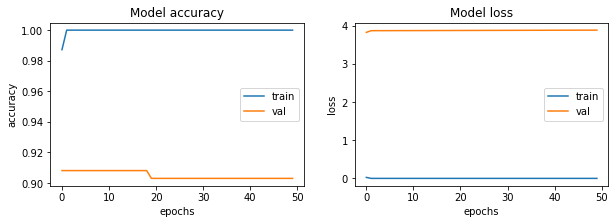

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [16]:
from sklearn.metrics import classification_report

y_pred = models.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
print(np.unique(y_pred_bool))


report = classification_report(y_test, y_pred_bool, output_dict=True)
print(classification_report(y_test, y_pred_bool))

[0 1 2]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        82
           1       0.90      0.98      0.94        82
           2       0.97      0.88      0.92        82

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



In [17]:

from tensorflow.keras.utils import plot_model

############## Make Sure to Change this ####################
plot_save_path = '/content/drive/My Drive/Results/ModelPlot/'
hist_save_path = '/content/drive/My Drive/Results/History/'
result_save_path = '/content/drive/My Drive/Results/Result/'
confusion_matrix_save_path = '/content/drive/My Drive/Results/Confusion Matrix/'


hist_df = pd.DataFrame(hist.history)
hist_csv_file = hist_save_path+model_name+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plot_model(models, plot_save_path+model_name+'.png', show_shapes=True)

result_df = report
result_df = pd.DataFrame(result_df).transpose()

print(result_df)

result_df.to_csv(result_save_path+model_name+'_result.csv')

              precision    recall  f1-score    support
0              0.987952  1.000000  0.993939   82.00000
1              0.898876  0.975610  0.935673   82.00000
2              0.972973  0.878049  0.923077   82.00000
accuracy       0.951220  0.951220  0.951220    0.95122
macro avg      0.953267  0.951220  0.950896  246.00000
weighted avg   0.953267  0.951220  0.950896  246.00000


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


CONFUSION MATRIX ------------------


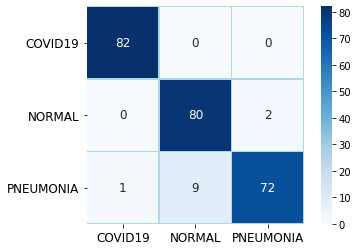

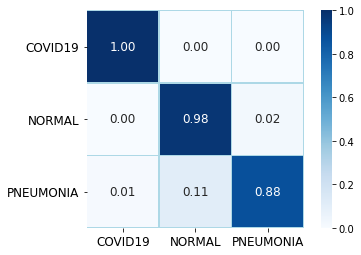

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
from seaborn import heatmap
from matplotlib import pyplot as plt

preds = np.argmax(models.predict(X_test), axis=1)
acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))
cm_norm = confusion_matrix(y_test, np.round(preds), normalize='true')
#tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')

ax = heatmap(cm, cmap='Blues', linecolor='lightblue',linewidths=.5,annot=True,annot_kws={'size': 12}, xticklabels=['COVID19', 'NORMAL','PNEUMONIA'], yticklabels=['COVID19', 'NORMAL','PNEUMONIA'], square=True, fmt='d')

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12,rotation=0)

plt.savefig(confusion_matrix_save_path+model_name+'.png',dpi=300)
plt.show()

ax = heatmap(cm_norm, cmap='Blues', annot=True,linecolor='lightblue',linewidths=.5,annot_kws={'size': 12}, xticklabels=['COVID19', 'NORMAL','PNEUMONIA'], yticklabels=['COVID19', 'NORMAL','PNEUMONIA'], square=True, fmt='.2f')

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12,rotation=0)

plt.savefig(confusion_matrix_save_path+model_name+'_normalized.png',dpi=300)